In [1]:
#pip install -r requirements.txt

In [2]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [3]:
# Load the data
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')
store_data = pd.read_csv('./data/store.csv')

/var/folders/tw/2zt46ypn7yj6b33zshj2_gt00000gn/T/ipykernel_80468/2448465800.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv('./data/train.csv')


# EDA

In [4]:
# EDA function
def EDA(df):
    print(df.head())
    print('------------------------------------------------------------------------')
    print(df.describe())
    print('------------------------------------------------------------------------')
    print(df.isnull().mean() * 100)
    print('------------------------------------------------------------------------')
    print(df.dtypes)


### Train data set

In [5]:
EDA(train_data)

   Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday   
0      1          5  2015-07-31   5263        555     1      1            0  \
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1  
------------------------------------------------------------------------
              Store     DayOfWeek         Sales     Customers          Open   
count  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06  \
mean   5.584297e+02  3.998341e+00  5.773819e+03  6.331459e+02  8.301067e-01   
std    3.219087e+02  1.997391e+00  3.849926e+03  4.644117e+02  3.755392e-01   
min    1.000000e+00  1

Check there is no sales when the store is closed:

In [6]:
train_data[(train_data['Open']==0) & (train_data['Sales']!=0)]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday


Check of train set time span:

In [7]:
train_data['Date'].min(), train_data['Date'].max()

('2013-01-01', '2015-07-31')

Check if days of the week are equally distributed:

In [8]:
train_data['DayOfWeek'].value_counts()
#the data missing seems to however be systematic, 
#so a deeper analysis may reveal the reason, and could help the imputation

DayOfWeek
5    145845
4    145845
3    145665
2    145664
1    144730
7    144730
6    144730
Name: count, dtype: int64

Check number of stores:

In [9]:
train_data['Store'].value_counts()
#1115 stores in total

Store
1      942
726    942
708    942
709    942
713    942
      ... 
159    758
637    758
636    758
633    758
155    758
Name: count, Length: 1115, dtype: int64

#### Feature engineering

In [10]:
#I will simplify the model by not accounting for which type of state holiday the day is
train_data['StateHoliday'] = np.where(train_data['StateHoliday']!=0, 1, train_data['StateHoliday']) 

#I convert the Date column to datetime so I can easily calculate time differences and 
#extract meaningful information such as year and month
train_data['Date'] = pd.to_datetime(train_data['Date'], format='%Y-%m-%d')
train_data['month'] = train_data['Date'].dt.month
train_data['year'] = train_data['Date'].dt.year

### Store data set

In [11]:
EDA(store_data)

   Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth   
0      1         c          a               1270.0                        9.0  \
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear   
0                    2008.0       0              NaN              NaN  \
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   
3                    2009.0       0              NaN              NaN   
4                    2015.0       0              NaN              NaN   

     PromoInterval  
0              NaN  
1  Jan,Apr,Jul,Oct  
2  Jan,Apr,

In [12]:
#Data with CompetitionOpenSinceMonth can have CompetitionDistance column non-NULL 
store_data[store_data['CompetitionOpenSinceMonth'].isna()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...
1095,1096,a,c,1130.0,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
1099,1100,a,a,540.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


#### Feature engineering

In [13]:
#create has_competition column based on competition year and distance being NULL, 
#use it to fill in NULLs in CompetitionDistance and CompetitionOpenSinceYear
store_data['has_competition'] = np.where((store_data['CompetitionOpenSinceYear'].isna() & 
                                                   store_data['CompetitionDistance'].isna()), 0, 1)
store_data['CompetitionDistance'] = np.where(store_data['has_competition']==0, 0, 
                                                     store_data['CompetitionDistance'])
store_data['CompetitionOpenSinceYear'] = np.where(store_data['has_competition']==0, 0, 
                                                     store_data['CompetitionOpenSinceYear'].min())
#Encode object type columns
assortment_d = {'a': 0,'b': 1,'c': 2}
storetype_d = {'a': 0,'b': 1,'c': 2, 'd':3}
store_data['Assortment'] = store_data['Assortment'].map(assortment_d)
store_data['StoreType'] = store_data['StoreType'].map(storetype_d)

### Test data set

In [14]:
EDA(test_data)

   Id  Store  DayOfWeek        Date  Open  Promo StateHoliday  SchoolHoliday
0   1      1          4  2015-09-17   1.0      1            0              0
1   2      3          4  2015-09-17   1.0      1            0              0
2   3      7          4  2015-09-17   1.0      1            0              0
3   4      8          4  2015-09-17   1.0      1            0              0
4   5      9          4  2015-09-17   1.0      1            0              0
------------------------------------------------------------------------
                 Id         Store     DayOfWeek          Open         Promo   
count  41088.000000  41088.000000  41088.000000  41077.000000  41088.000000  \
mean   20544.500000    555.899533      3.979167      0.854322      0.395833   
std    11861.228267    320.274496      2.015481      0.352787      0.489035   
min        1.000000      1.000000      1.000000      0.000000      0.000000   
25%    10272.750000    279.750000      2.000000      1.000000      0.0

In [15]:
test_data[test_data['Open'].isna()]

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
479,480,622,4,2015-09-17,NaN,1,0,0
1335,1336,622,3,2015-09-16,NaN,1,0,0
2191,2192,622,2,2015-09-15,NaN,1,0,0
3047,3048,622,1,2015-09-14,NaN,1,0,0
4759,4760,622,6,2015-09-12,NaN,0,0,0
5615,5616,622,5,2015-09-11,NaN,0,0,0
6471,6472,622,4,2015-09-10,NaN,0,0,0
7327,7328,622,3,2015-09-09,NaN,0,0,0
8183,8184,622,2,2015-09-08,NaN,0,0,0
9039,9040,622,1,2015-09-07,NaN,0,0,0


Differences between columns in test and train set:

In [16]:
test_data.columns

Index(['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday'],
      dtype='object')

In [17]:
train_data.columns
#The column Id and Customers are present in the test data but not in the train

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'month', 'year'],
      dtype='object')

Check time frame of test set

In [18]:
test_data['Date'].min(), test_data['Date'].max()

('2015-08-01', '2015-09-17')

Check if all stores in the test set are present in store data set

In [19]:
test_data[~test_data['Store'].isin(store_data['Store'])]['Store']
#All stores in the test set appear in the store data as well

Series([], Name: Store, dtype: int64)

### Further EDA

Explore data stationarity, seasonality and presence of autocorrelation.
The analysis is purely qualitative, performed at the week level because some day values are missing, and averaged across all stores. It is aimed at informing which further transformation in the data could help the prediction.

In [20]:
store_sales = train_data.copy()
store_sales = store_sales.set_index('Date').to_period('W')
store_sales = store_sales.set_index(['Store'], append=True)

store_sales

DayOfWeek  Sales  Customers  Open  Promo   
Date                  Store                                             
2015-07-27/2015-08-02 1              5   5263        555     1      1  \
                      2              5   6064        625     1      1   
                      3              5   8314        821     1      1   
                      4              5  13995       1498     1      1   
                      5              5   4822        559     1      1   
...                                ...    ...        ...   ...    ...   
2012-12-31/2013-01-06 1111           2      0          0     0      0   
                      1112           2      0          0     0      0   
                      1113           2      0          0     0      0   
                      1114           2      0          0     0      0   
                      1115           2      0          0     0      0   

                            StateHoliday  SchoolHoliday  month  year  
Date                  Store                                           
2015-07-27/2015-08-02 1                1              1      7  2015  
                      2                1              1      7  2015  
                      3                1              1      7  2015  
                      4                1              1      7  2015  
                      5                1              1      7  2015  
...                                  ...            ...    ...   ...  
2012-12-31/2013-01-06 1111             1              1      1  2013  
                      1112             1              1      1  2013  
                      1113             1              1      1  2013  
                      1114             1              1      1  2013  
                      1115             1              1      1  2013  

[1017209 rows x 9 columns]

In [21]:
average_sales = store_sales.groupby(['Date'])['Sales'].mean()


In [22]:
avg_sales_df = average_sales.to_frame()
time = np.arange(len(avg_sales_df.index))
avg_sales_df['time'] = time 

#Training a simple regression model helps to see if the series is stationary
X = avg_sales_df.loc[:, ['time']]  
y = avg_sales_df.loc[:, 'Sales'] 

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

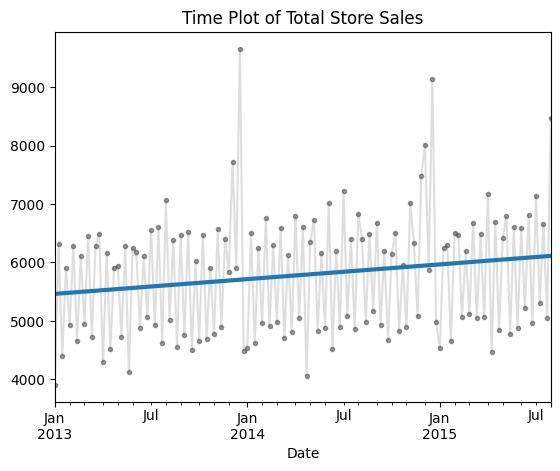

In [23]:
plot_params = dict(
    color='0.75',
    style='.-',
    markeredgecolor='0.25',
    markerfacecolor='0.25',
    legend=False,
)

ax = y.plot(**plot_params, alpha=0.5)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Total Store Sales');

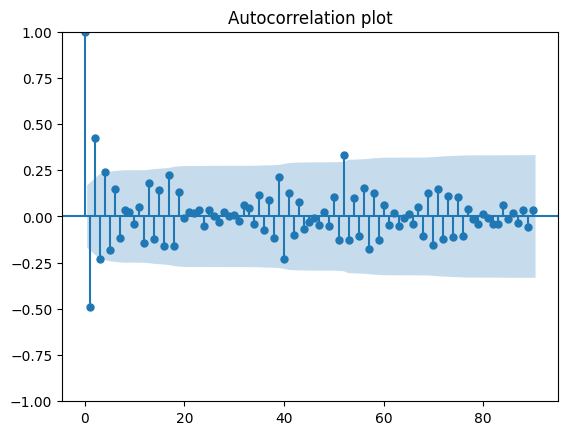

In [24]:
plot_acf(average_sales, lags = 90, title = 'Autocorrelation plot')
plt.show()

- The time series shows seasonality and appears to be non-stationary
- Lag 1 and 2 are statistically significant

### Create final train set

In [25]:
train_data_merged = train_data.merge(store_data, on = ['Store'])

In [26]:
#Create years of competition feature
train_data_merged['CompetitionTimeDistance'] = train_data_merged['year'] - train_data_merged['CompetitionOpenSinceYear']
train_data_merged['CompetitionTimeDistance'] = np.where(train_data_merged['CompetitionTimeDistance']<0, 0, train_data_merged['CompetitionTimeDistance'])



In [27]:
#Cast bool cols into int
train_data_merged=train_data_merged.replace(False, 0)
train_data_merged=train_data_merged.replace(True, 1)

In [28]:
train_data_merged.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'month', 'year', 'StoreType',
       'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'has_competition',
       'CompetitionTimeDistance'],
      dtype='object')

### Explore correlation between columns

In [29]:
corr_analysis_df = train_data_merged[['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 
                                      'Promo', 'StateHoliday', 'SchoolHoliday', 'month', 
                                      'year', 'StoreType', 'Assortment', 'CompetitionDistance', 
                                      'CompetitionOpenSinceYear', 'Promo2', 'CompetitionTimeDistance']]



In [30]:
corr = corr_analysis_df.corr()
corr.style.background_gradient(cmap='coolwarm')

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,month,year,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceYear,Promo2,CompetitionTimeDistance
Store,1.000000,-0.000008,0.005126,0.024325,-0.000047,0.000058,-0.000404,0.000641,0.001467,0.000290,-0.021604,0.004419,-0.026486,-0.003057,0.008488,0.003060
DayOfWeek,-0.000008,1.000000,-0.462125,-0.386445,-0.528963,-0.392925,0.004594,-0.205388,-0.005362,0.001937,0.000051,-0.000052,-0.000025,-0.000013,0.000168,0.000029
Sales,0.005126,-0.462125,1.000000,0.894711,0.678472,0.452345,0.004025,0.085124,0.048768,0.023519,-0.013057,0.074941,-0.018609,0.016408,-0.091040,-0.016219
Customers,0.024325,-0.386445,0.894711,1.000000,0.616768,0.316169,-0.007478,0.071568,0.038179,-0.001212,-0.141423,0.007044,-0.102022,0.019304,-0.150159,-0.019313
Open,-0.000047,-0.528963,0.678472,0.616768,1.000000,0.295042,-0.026067,0.086171,-0.000681,-0.001009,-0.003325,0.002972,0.007989,0.000367,-0.008309,-0.000375
Promo,0.000058,-0.392925,0.452345,0.316169,0.295042,1.000000,0.002313,0.067483,-0.011747,0.024300,-0.000299,0.000294,0.000141,0.000078,-0.000983,0.000117
StateHoliday,-0.000404,0.004594,0.004025,-0.007478,-0.026067,0.002313,1.000000,-0.051111,0.084681,-0.082969,0.005239,-0.005277,-0.002575,-0.001409,0.017376,0.000742
SchoolHoliday,0.000641,-0.205388,0.085124,0.071568,0.086171,0.067483,-0.051111,1.000000,0.103282,-0.036535,0.000032,-0.002530,-0.003651,0.000856,-0.006909,-0.001150
month,0.001467,-0.005362,0.048768,0.038179,-0.000681,-0.011747,0.084681,0.103282,1.000000,-0.269382,-0.007692,0.007601,0.003643,0.002010,-0.025323,-0.004175
year,0.000290,0.001937,0.023519,-0.001212,-0.001009,0.024300,-0.082969,-0.036535,-0.269382,1.000000,-0.001514,0.001494,0.000716,0.000395,-0.004982,0.007643


- sales highly correlate with number of customers and store being open and day of the week (as expected)
- the column CompetitionOpenSinceYear highly correlates with CompetitionTimeDistance (I can discard one of these to improve training time)


## Model

In [31]:
X = train_data_merged[['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                       'month', 'year', 'StoreType', 'Assortment', 'CompetitionDistance', 
                       'Promo2', 'CompetitionTimeDistance']]
y = train_data_merged['Sales']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [33]:
rfe = RandomForestRegressor(max_depth=10)
fit = rfe.fit(X_train, y_train)
y_pred = fit.predict(X_test)

In [34]:
rmse = mean_squared_error(y_test, y_pred, squared=True)
rmse

5685602.377504312

### Scatter plot of predictions

Text(0, 0.5, 'Predictions')

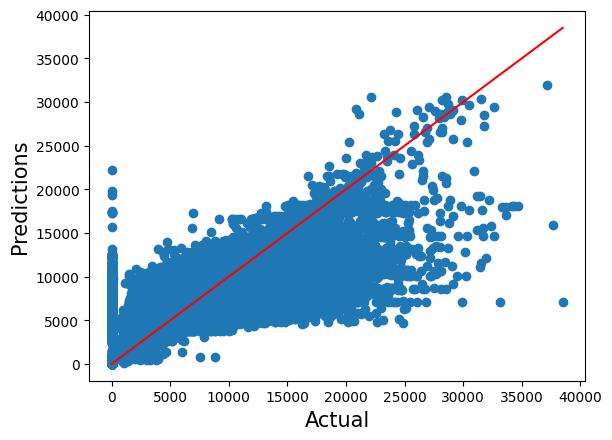

In [35]:
plt.scatter(y_test, y_pred)
p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'r-')
plt.xlabel('Actual', fontsize=15)
plt.ylabel('Predictions', fontsize=15)

### Plot of residuals

Text(0, 0.5, 'Residuals')

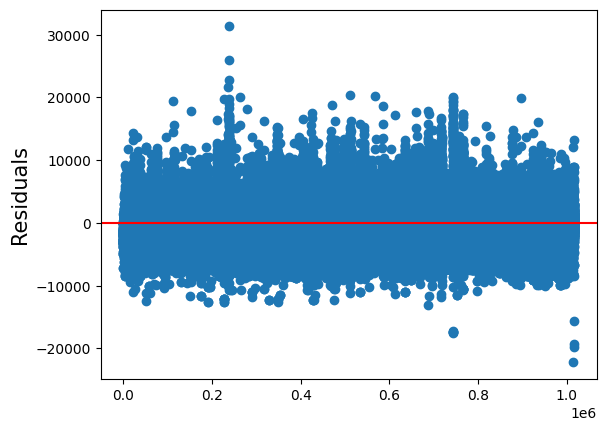

In [36]:
plt.plot(y_test - y_pred,marker='o', linestyle='')
plt.axhline(y=0, color='r', linestyle='-')
plt.ylabel('Residuals', fontsize=15)

Considerations on model:

    - the residuals are randomly distributed around 0 which suggests that the model captures the autocorrelation
    - however the model seems to over-estimate smaller values and under-estimate higher values, which suggests it is not able to capture the seasonality/non-stationarity in the data
    - the model also fails to correctly identify days when the store will be closed

## Make predictions file

In [37]:
#apply same transformations to test data set as to train data set
def transform_test_set(df, store_data=store_data):
    df['StateHoliday'] = np.where(df['StateHoliday']!=0, 1, df['StateHoliday']) 
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df_merged = df.merge(store_data, on = ['Store'])
    df_merged['CompetitionTimeDistance'] = df_merged['year'] - df_merged['CompetitionOpenSinceYear']
    df_merged['CompetitionTimeDistance'] = np.where(df_merged['CompetitionTimeDistance']<0, 0, df_merged['CompetitionTimeDistance'])
    df_merged=df_merged.replace(False, 0)
    df_merged=df_merged.replace(True, 1)

    return df_merged[['Store', 'DayOfWeek', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'month', 'year', 'StoreType',
       'Assortment', 'CompetitionDistance', 'Promo2',
       'CompetitionTimeDistance']]

In [38]:
df_test = transform_test_set(test_data)

In [39]:
y_test_pred = fit.predict(df_test)

In [40]:
y_test_pred

array([7131.72586576, 7131.72586576, 8023.72805486, ..., 9246.26042759,
          0.        , 5983.77683588])

In [42]:
pd.DataFrame(y_test_pred, columns=['predictions']).to_csv('./predictions_file.csv')


## Final considerations

As discussed, the model does not seem to correctly account for the seasonality and non-stationarity of the data. Therefore, to improve its predictive power, it is possible to make the data stationary and de-seasonalize it (although as mentioned this means facing the issue with missing day data).
There seems to also be an issue with correctly predicting when the store will be closed (and therefore 0 sales): to improve this another variable (like a boolean value for isWeekend) can be added, furthermore holidays (since they are known) can be marked as such in the test data set beforehand.

Adding further features (such as the Promo2 details) and tuning of hyperparameters could also help the prediction.


RMSE, as well as the predictions and residuals plots, could be used to measure how adding further features and properly trasforming the data can improve the prediction.